In [1]:
import sacc
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pylab as plt 
import numpy as np
import pyccl as ccl
import classy

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
ZMAX = 2.0
ELLMIN = 2
NELL = 30
ELLMAX_GC = 300
ELLMAX_WL = 3000

jc.power.USE_EMU = False

In [3]:
def get_nz(sfile, tracertype="wl"):
    tracers_names = list(sfile.tracers.keys())

    if tracertype == "wl":
        tname = "DESwl__"
    else:
        tname = "DESgc__"
    nbin = sum([tname in tracers_names[i] for i in range(len(tracers_names))])

    nz_distributions = list()
    for i in range(nbin):
        name = tname + str(i)
        distribution = sfile.tracers[name]
        jaxred = jc.redshift.custom_nz(
            distribution.z.astype("float64"),
            distribution.nz.astype("float64"),
            zmax=ZMAX,
        )
        nz_distributions.append(jaxred)

    return nz_distributions

In [135]:
def unpack_params_vec(params):
    cosmo = jc.Cosmology(
        sigma8=params[0],
        Omega_c=params[1],
        Omega_b=params[2],
        h=params[3],
        n_s=params[4],
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    b1, b2, b3, b4, b5 = params[15], params[16], params[17], params[18], params[19]
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = (
        params[20],
        params[21],
        params[22],
        params[23],
        params[24],
    )
    return (
        cosmo,
        [mparam_1, mparam_2, mparam_3, mparam_4],
        [dz1, dz2, dz3, dz4],
        [a_ia_param, eta_param],
        [b1, b2, b3, b4, b5],
        [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5],
    )

def get_params_vec(cosmo, multiplicative, deltaz, ia_params, bias, deltaz_gc):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    b1, b2, b3, b4, b5 = bias
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = deltaz_gc
    return jnp.array(
        [
            cosmo.sigma8,
            cosmo.Omega_c,
            cosmo.Omega_b,
            cosmo.h,
            cosmo.n_s,
            mparam_1,
            mparam_2,
            mparam_3,
            mparam_4,
            dz1,
            dz2,
            dz3,
            dz4,
            a_ia_param,
            eta_param,
            b1,
            b2,
            b3,
            b4,
            b5,
            dz_gc_1,
            dz_gc_2,
            dz_gc_3,
            dz_gc_4,
            dz_gc_5,
        ]
    )


def get_test_param():
    cosmo = jc.Cosmology(
        sigma8=0.852,
        Omega_c=0.239,
        Omega_b=0.054,
        h=0.653,
        n_s=0.933,
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )

    parameter = get_params_vec(
        cosmo,
        [0.0, 0.0, 0.0, 0.0], # [0.074, 0.186, -0.075, -0.108], # multiplicative
        [0.0, 0.0, 0.0, 0.0], # [-0.008, -0.100, -0.0018, -0.0097], # shifts wl 
        [0.359, -0.011], # a_ia, eta
        [1.0, 1.0, 1.0, 1.0, 1.0], # [1.34, 1.58, 1.60, 1.90, 1.94], # biases 
        [0.0, 0.0, 0.0, 0.0, 0.0]#[0.022, -0.0015, 0.02, 0.0097, -0.012], # shifts gc
    )
    return parameter

def get_index_pairs(nbin1, nbin2=None, auto=False):
    cl_index = list()
    if nbin2 is not None:
        for i in range(nbin1):
            for j in range(nbin2):
                cl_index.append([i, j + nbin1])
    elif auto:
        for i in range(nbin1):
            cl_index.append([i, i])
    else:
        for i in range(nbin1):
            for j in range(i, nbin1):
                cl_index.append([i, j])
    return cl_index

In [136]:
saccfile = sacc.Sacc.load_fits("data/cls_DESY1.fits")
jax_nz_wl = get_nz(saccfile, tracertype="wl")
jax_nz_gc = get_nz(saccfile, tracertype="gc")
parameters = get_test_param()

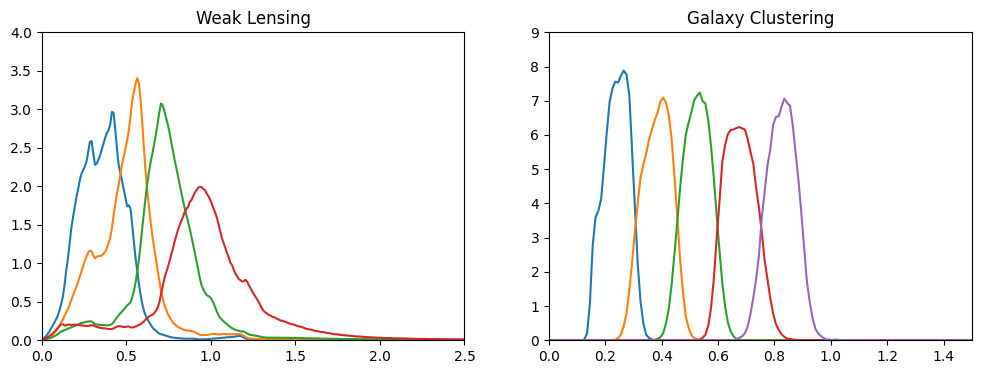

In [137]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title('Weak Lensing')
for i in range(4):
    plt.plot(jax_nz_wl[i].params[0], jax_nz_wl[i].params[1])
plt.ylim(0.0, 4.0)
plt.xlim(0.0, 2.5)

plt.subplot(122)
plt.title('Galaxy Clustering')
for i in range(5):
    plt.plot(jax_nz_gc[i].params[0], jax_nz_gc[i].params[1])
plt.ylim(0.0, 9.0)
plt.xlim(0.0, 1.5)
plt.show()

Weak Lensing only

In [138]:
cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters)
nbin_wl = len(deltaz_wl)
nbin_gc = len(deltaz_gc)

nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]

ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=jnp.float32)
idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
ps_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse, probes_wl, index_pairs=idx_pairs_wl)

Not using the emulator


Galaxy Clustering only

In [139]:
gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]
nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)]
probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]

ells_coarse_gc = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
ps_gc = jc.angular_cl.angular_cl(cosmo, ells_coarse_gc, probes_gc, index_pairs=idx_pairs_gc)

Not using the emulator


Weak Lensing and Galaxy Clustering

In [140]:
probes_gc_wl = probes_gc + probes_wl
idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
ps_gc_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse_gc, probes_gc_wl, index_pairs=idx_pairs_gc_wl)

Not using the emulator


# CCL

In [142]:
Omega_c = cosmo.Omega_c.item() 
Omega_b = cosmo.Omega_b.item() 
h = cosmo.h.item() 
sigma8 = cosmo.sigma8.item()
n_s = cosmo.n_s.item() 

In [143]:
cosmo_ref = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s, transfer_function='boltzmann_class')

### Calling CLASS explicitly

In [76]:
KMIN = 1E-4
KMAX = 50 
ZMIN = 0.0 
ZMAX = 3.0 

params = {
    "output": "mPk",
    "P_k_max_1/Mpc": KMAX,
    "z_max_pk": ZMAX,
    "h": h,
    "Omega_cdm": Omega_c,
    "Omega_b": Omega_b,
    "Omega_k": 0.,
    "n_s": n_s,
    "sigma8": sigma8,
    "N_ur": 3.046,
    "non linear": "halofit"
}
model = classy.Class()
model.set(params)
model.compute()

In [77]:
# Background
bg = model.get_background()
a_bg = 1/(1+bg['z'])
msk = a_bg > 0.002
a_bg = a_bg[msk]
# Distances
chi = bg['comov. dist.'][msk]
# Expansion rate
h_over_h0 = bg['H [1/Mpc]'][msk]
h_over_h0 /= h_over_h0[-1]

In [82]:
k_arr = np.logspace(np.log10(KMIN), np.log10(KMAX), 200)
a_arr = np.linspace(1.0 / (1.0 + ZMAX), 1.0 / (1.0 + ZMIN), 100)
# Linear
pkln = np.array([[model.pk_lin(k, 1./a-1) for k in k_arr] for a in a_arr])
# non-linear
pknl = np.array([[model.pk(k, 1./a-1) for k in k_arr] for a in a_arr])


cosmo_cal = ccl.CosmologyCalculator(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s,
                                    background={'a': a_bg, 'chi': chi, 'h_over_h0': h_over_h0},
                                    pk_linear={'a': a_arr, 'k': k_arr,
                                               'delta_matter:delta_matter': pkln},
                                    pk_nonlin={'a': a_arr, 'k': k_arr,
                                               'delta_matter:delta_matter': pknl})

### Weak Lensing

In [144]:
def intrinsic_alignment(redshift, amplitude, eta, redshift_fixed = 0.62):
    return amplitude * ((1 + redshift) / (1 + redshift_fixed)) ** eta

In [145]:
cl_wl_ccl = []
for i in range(nbin_wl):
    for j in range(i, nbin_wl):
        z_i = nz_wl_sys[i].params[0].params[0]
        z_j = nz_wl_sys[j].params[0].params[0]
        
        nz_i = nz_wl_sys[i].params[0].params[1]
        nz_j = nz_wl_sys[j].params[0].params[1]

        m_i = multiplicative[i].item()
        m_j = multiplicative[j].item()
        
        A_IA_i = intrinsic_alignment(z_i, a_ia_param, eta_param)
        A_IA_j = intrinsic_alignment(z_j, a_ia_param, eta_param)
        
        t1 = ccl.WeakLensingTracer(cosmo_ref, dndz=(z_i, nz_i), has_shear=True, ia_bias=(z_i, A_IA_i))
        t2 = ccl.WeakLensingTracer(cosmo_ref, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
        
        # t1 = ccl.WeakLensingTracer(cosmo_cal, dndz=(z_i, nz_i), ia_bias=(z_i, A_IA_i))
        # t2 = ccl.WeakLensingTracer(cosmo_cal, dndz=(z_j, nz_j), ia_bias=(z_j, A_IA_j))
        
        cl = ccl.angular_cl(cosmo_ref, t1, t2, ells_coarse)  * (1.0 + m_i) * (1.0 + m_j)
        cl_wl_ccl.append(cl)

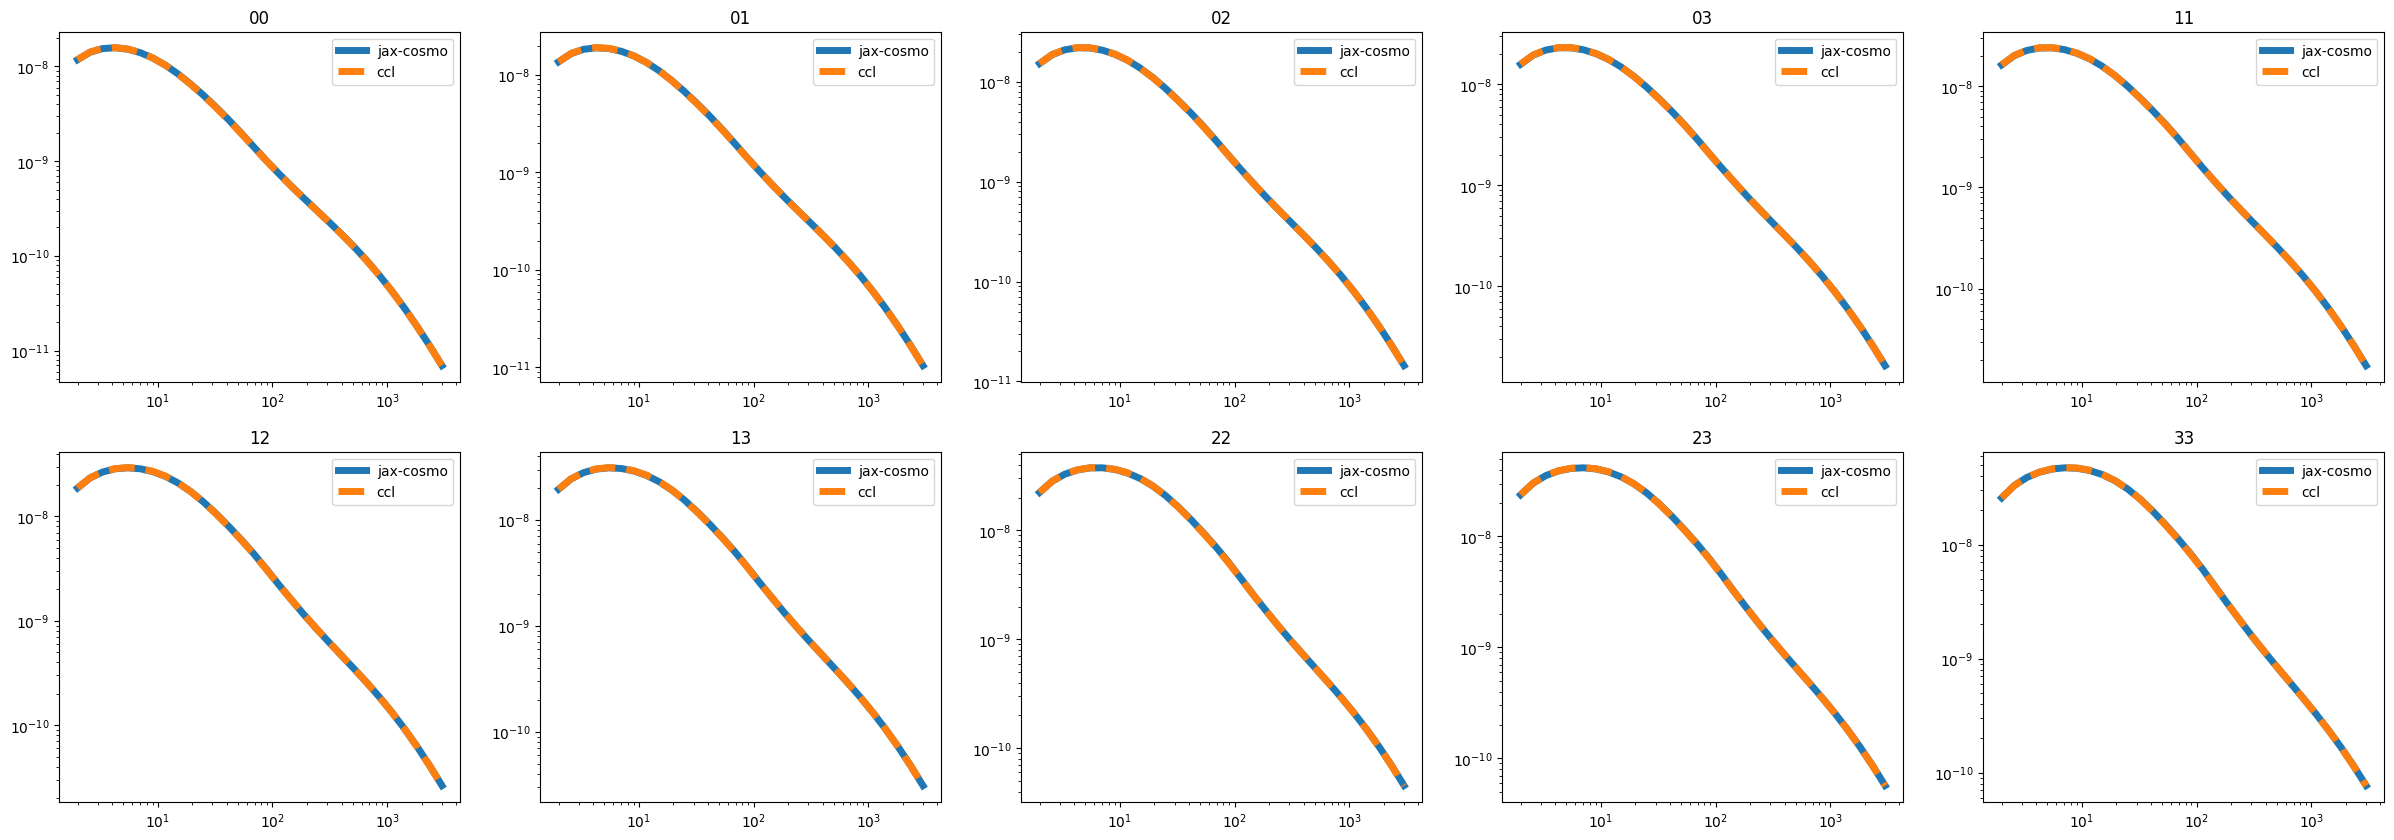

In [149]:
plt.figure(figsize = (30, 10))
counter = 0 
for i in range(4):
    for j in range(i, 4):
        plt.subplot(2, 5, counter+1)
        plt.title(f'{i}{j}')
        plt.loglog(ells_coarse, ps_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse, cl_wl_ccl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.legend()
        counter += 1
plt.show()

### Galaxy Clustering

In [151]:
cl_gc_ccl = []
for i in range(nbin_gc):
    z = nz_gc_sys[i].params[0].params[0]
    nz = nz_gc_sys[i].params[0].params[1]
    b = bias[i].item()
    tracer = ccl.tracers.NumberCountsTracer(cosmo_ref, dndz=(z, nz), bias = (z, b*np.ones_like(z)), has_rsd=False)
    # tracer = ccl.tracers.NumberCountsTracer(cosmo_cal, dndz=(z, nz), bias = (z, b*np.ones_like(z)), has_rsd=False)
    cl = ccl.angular_cl(cosmo_ref, tracer, tracer, ells_coarse_gc)
    cl_gc_ccl.append(cl)

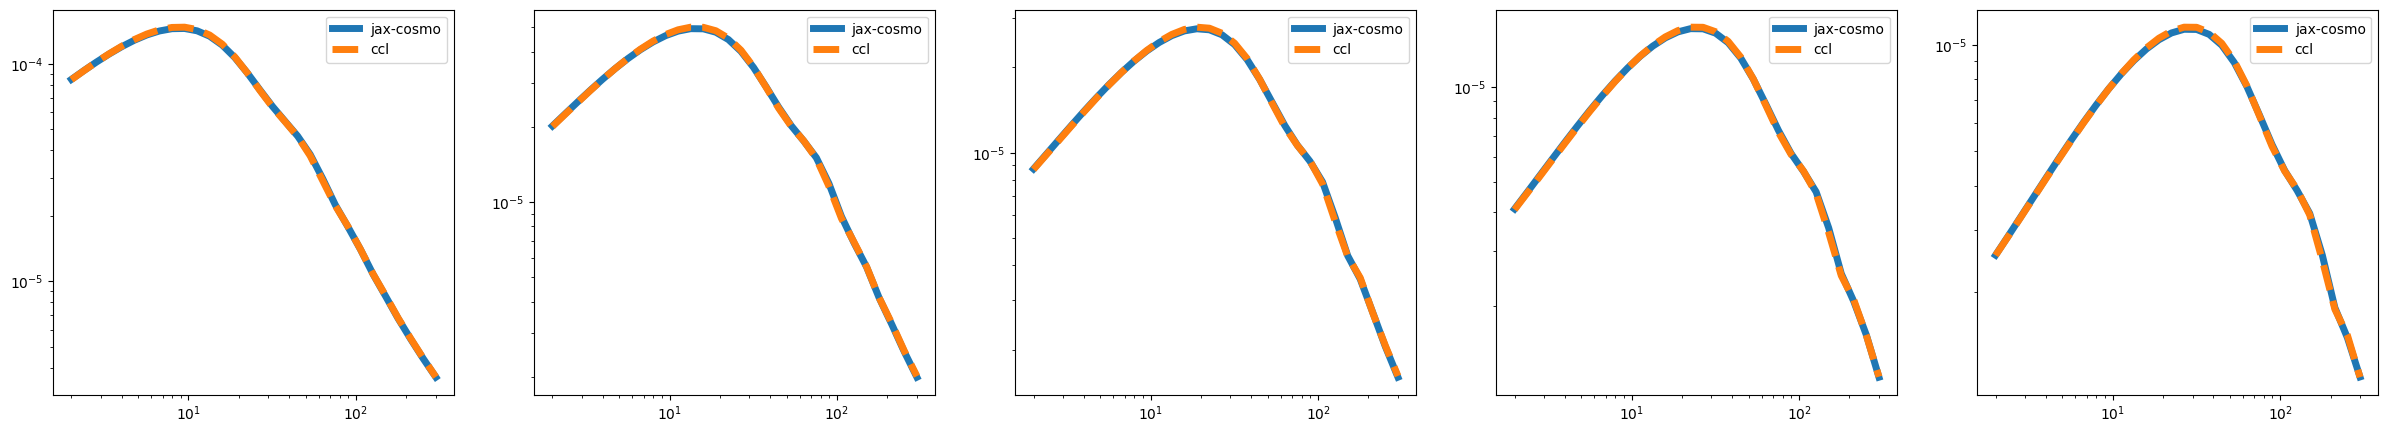

In [152]:
plt.figure(figsize = (30, 5))
for i in range(nbin_gc):
    plt.subplot(1, nbin_gc, i+1)
    plt.loglog(ells_coarse_gc, ps_gc[i], label = 'jax-cosmo', lw = 5)
    plt.loglog(ells_coarse_gc, cl_gc_ccl[i], label = 'ccl', linestyle = '--', lw = 5)
    plt.legend()
plt.show()

### Weak Lensing and Galaxy Clustering

In [160]:
cl_gc_wl_ccl = []
for i in range(nbin_gc):
    for j in range(nbin_wl):

        # gc 
        z_i = nz_gc_sys[i].params[0].params[0]
        nz_i = nz_gc_sys[i].params[0].params[1]
        b_i = bias[i].item()
        # t_i = ccl.tracers.NumberCountsTracer(cosmo_ref, dndz=(z_i, nz_i), bias = (z_i, b_i*np.ones_like(z_i)), has_rsd=False)
        t_i = ccl.tracers.NumberCountsTracer(cosmo_cal, dndz=(z_i, nz_i), bias = (z_i, b_i*np.ones_like(z_i)), has_rsd=False)
    
        # wl 
        z_j = nz_wl_sys[j].params[0].params[0]
        nz_j = nz_wl_sys[j].params[0].params[1]
        m_j = multiplicative[j].item()
        A_IA_j = intrinsic_alignment(z_j, a_ia_param, eta_param)
        # t_j = ccl.WeakLensingTracer(cosmo_ref, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
        t_j = ccl.WeakLensingTracer(cosmo_cal, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))

        # calculate the cls 
        cl = ccl.angular_cl(cosmo_ref, t_i, t_j, ells_coarse_gc)  * (1.0 + m_j)
        cl_gc_wl_ccl.append(cl)

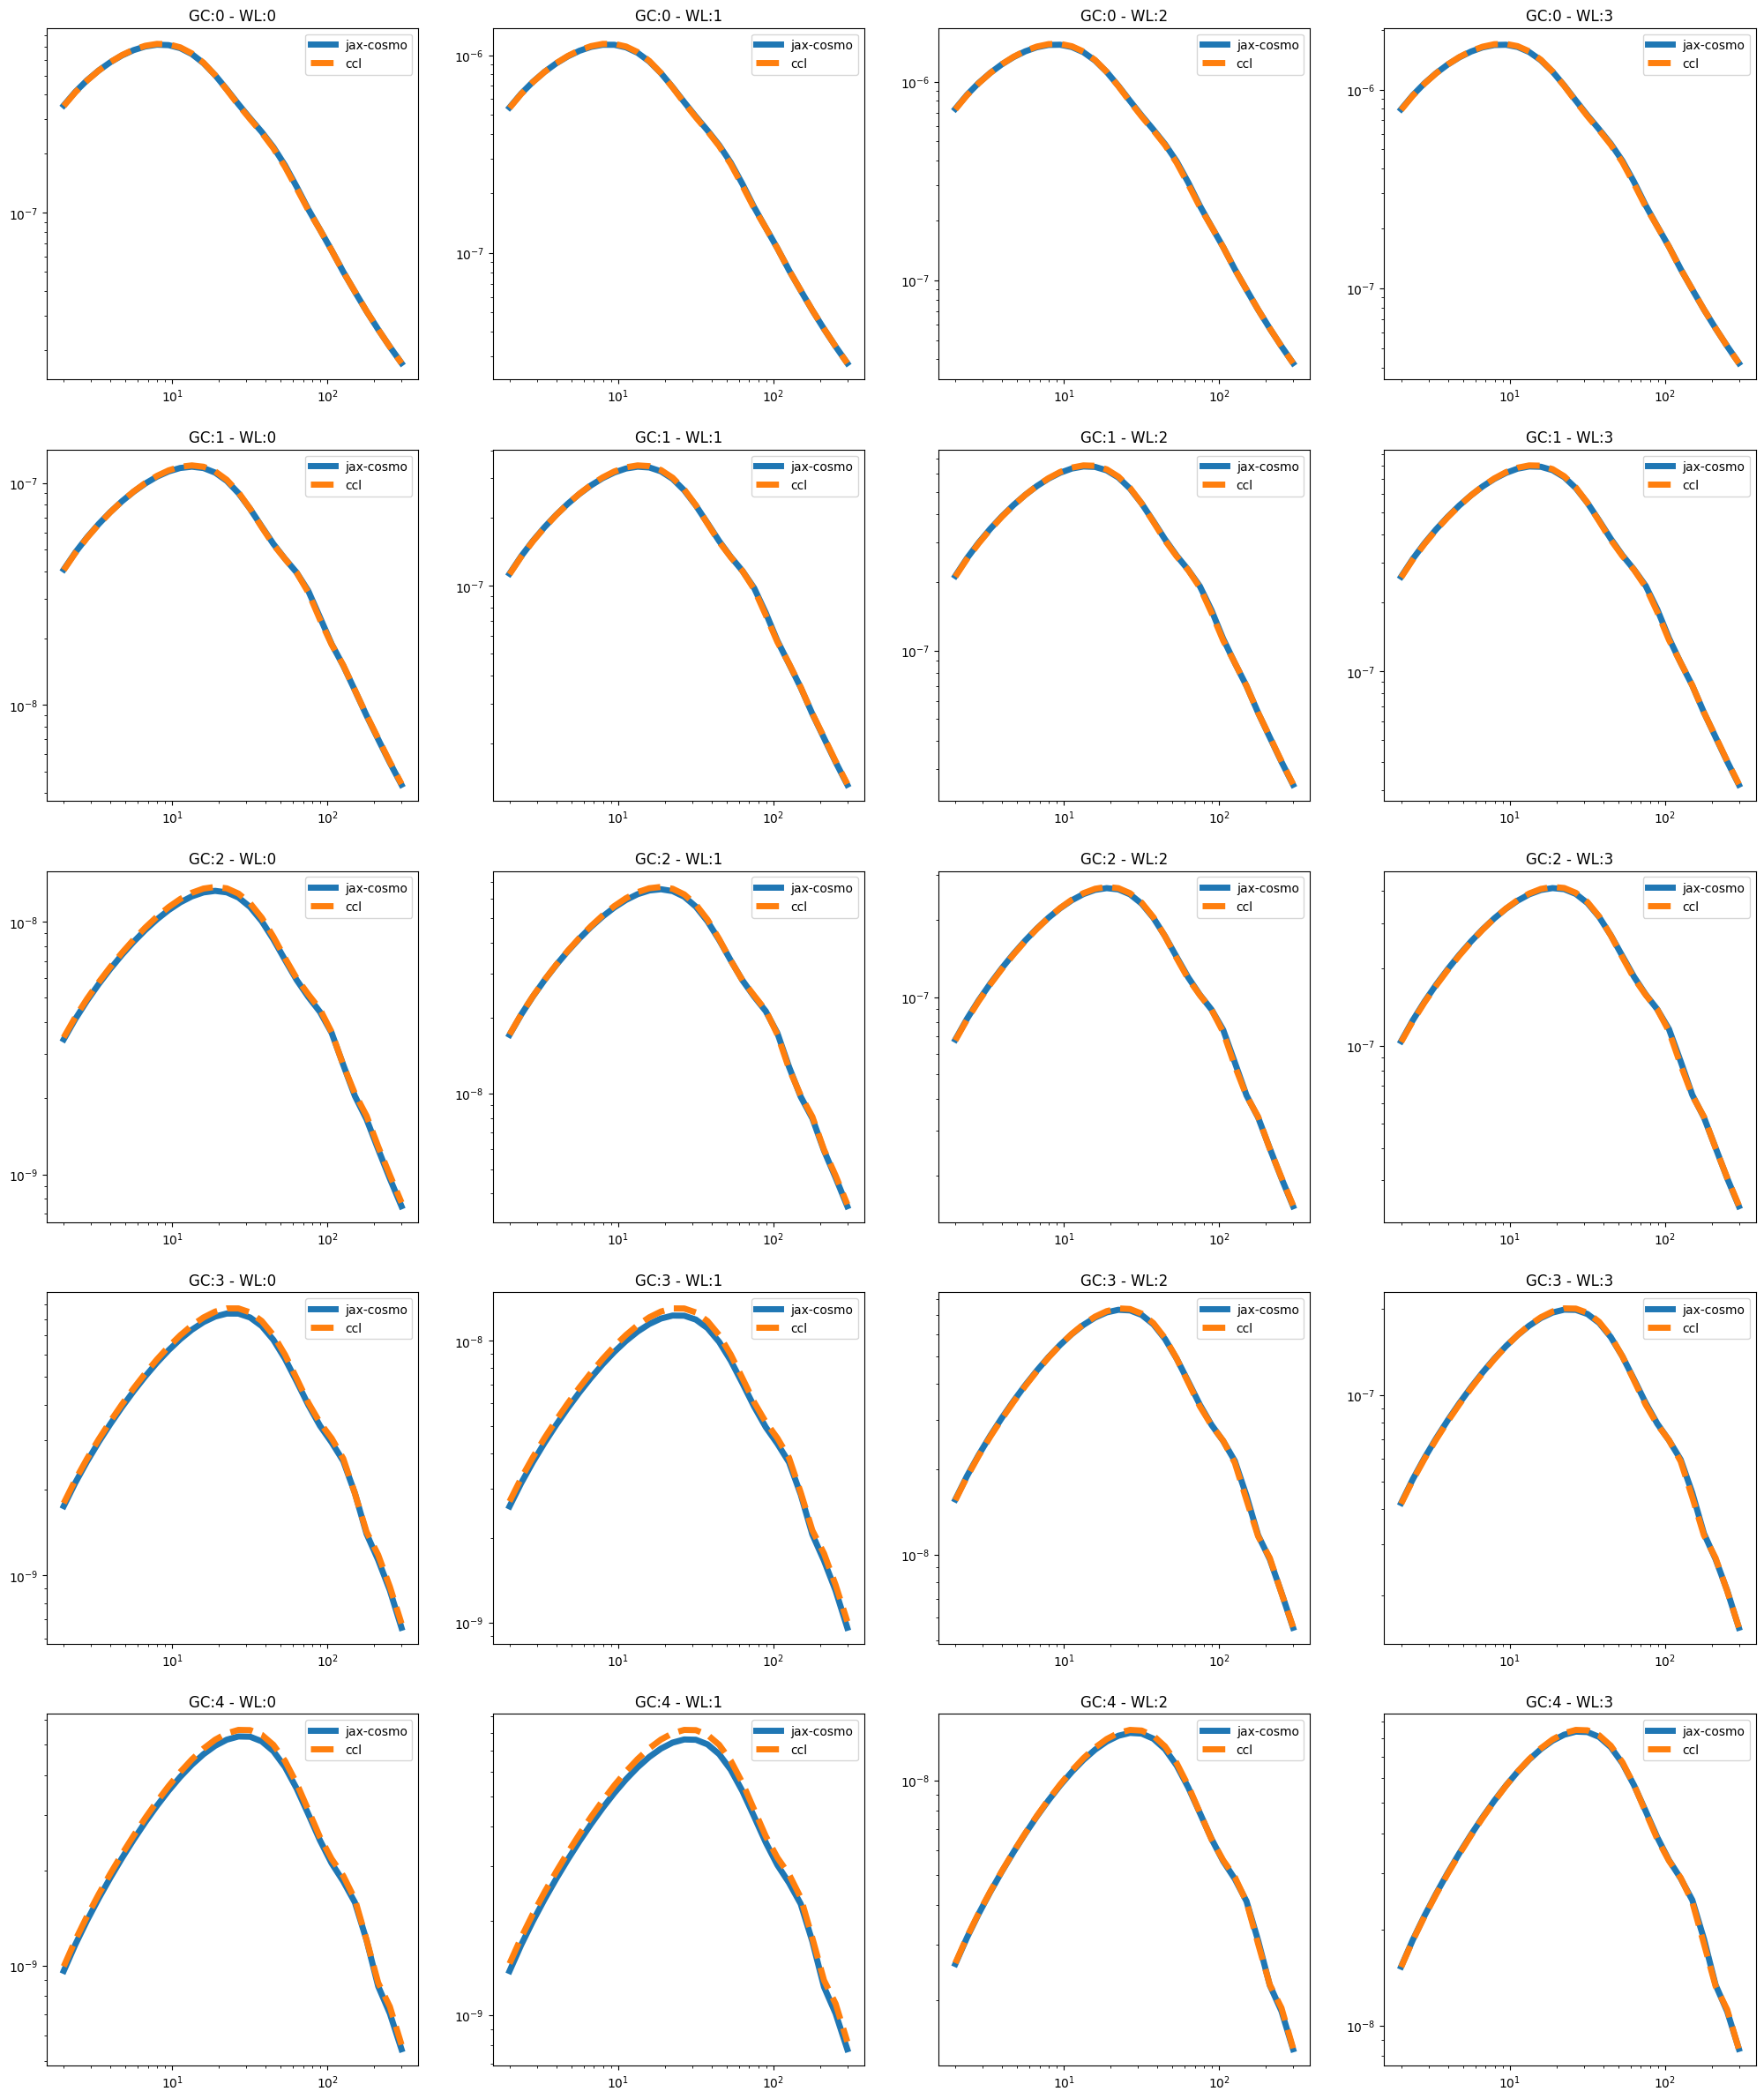

In [161]:
plt.figure(figsize = (25, 30))
counter = 0 
for i in range(nbin_gc):
    for j in range(nbin_wl):
        plt.subplot(nbin_gc, nbin_wl, counter+1)
        plt.title(f'GC:{i} - WL:{j}')
        plt.loglog(ells_coarse_gc, ps_gc_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_gc, cl_gc_wl_ccl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.legend()
        counter += 1
# plt.savefig('plots/test-power-spectra.png')
plt.show()